## This notebook compiles object-location scoring output from behavior_coding.py. 
*Data standard assumptions:*
* video name in *_ol_scoring.csv matches vidname in metadata csv. 
* *_ol_scoring.csv contains headers 'file','frame','action'


In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import sys

sys.path.append('C:/Users/schafferlab/github/SNLab_ephys/behavior/')

import process_behavior_coding as bc

### Set paths

In [3]:
data_dir = 'Y:/laura_berkowitz/app_ps1_ephys/data'
meta_path = 'Y:/laura_berkowitz/app_ps1_ephys/behavior/object_location/object_location_metadata.csv'
save_path = 'Y:/laura_berkowitz/app_ps1_ephys/behavior/object_location/'

### Import meta data and compile object-location coding into dataframe

In [4]:
# load metadata
metadata = pd.read_csv(meta_path)
metadata.describe()

# load compiled data
df = bc.load_data(data_dir)
df.dropna(inplace=True) # drop rows with NaN
df.reset_index(drop = True,inplace=True) # reset index

# check if starts always follow stops 
check_index = bc.check_start_stop(df)
if len(check_index) > 0:
    RaiseException('Stop and check data for errors')

# make two new columns, one for object and one for action made
df[['object','action']] = df.action.str.split('_', expand=True)
df['object'] = df.object.str.replace('object','')

### Reorganize data frame so each row is visit for object 1 or object 2 

In [5]:
# create dataframe where each row is a visit to object 1 or object 2
df_visit = pd.DataFrame(columns = ['file','start','stop','object'])
for file in df.file.unique():
    temp_df = df[df.file == file].copy()
    object_1_idx = temp_df.object == '1'
    object_2_idx = temp_df.object == '2'

    if np.sum(object_1_idx) % 2 == 1:
        raise Exception('Object 1 has an odd number of starts and stops')
    if np.sum(object_2_idx) % 2 == 1:
        raise Exception('Object 2 has an odd number of starts and stops')
    
    d = []
    for idx, i in enumerate(range(0,len(temp_df),2)):
        d.append(
            {'file': temp_df.iloc[i].file,
                'start': temp_df.iloc[i].frame,
                'stop': temp_df.iloc[i+1].frame,
                'object': temp_df.iloc[i].object
            }
        )
    
    df_visit = pd.concat([df_visit, pd.DataFrame(d)], ignore_index=True)

df_visit.reset_index(drop = True,inplace=True)
df_visit


,file,start,stop,object
0,Y:/laura_berkowitz/app_ps1_ephys/data/hpc04/hp...,1553.0,1620.0,1
1,Y:/laura_berkowitz/app_ps1_ephys/data/hpc04/hp...,1871.0,1983.0,2
2,Y:/laura_berkowitz/app_ps1_ephys/data/hpc04/hp...,4155.0,4278.0,2
3,Y:/laura_berkowitz/app_ps1_ephys/data/hpc04/hp...,4605.0,4752.0,2
4,Y:/laura_berkowitz/app_ps1_ephys/data/hpc04/hp...,12513.0,12604.0,2
...,...,...,...,...
2134,//10.253.5.16/sn data server 3/laura_berkowitz...,68495.0,68776.0,1
2135,//10.253.5.16/sn data server 3/laura_berkowitz...,68856.0,68921.0,1
2136,//10.253.5.16/sn data server 3/laura_berkowitz...,70697.0,70719.0,2
2137,//10.253.5.16/sn data server 3/laura_berkowitz...,79317.0,79332.0,2


### Add metadata to compiled df and save

In [6]:
# add metadata to dataframe
df_visit = bc.add_metadata(df_visit, metadata)
# create column for for visit time in seconds
df1= bc.frames_to_seconds(df_visit, fs = 60)


### Add indicators factors to df1 for object exploration examination: 
* object exploration (in seconds)
* first 5 min (boolean)
* first 3 min (boolean)
* trial n (integer representing trial)


In [7]:
df1['object_exploration_time'] = df1.stop - df1.start
df1['first_5min'] = df1.stop.apply(lambda x: x < 300)
df1['first_3min'] = df1.stop.apply(lambda x: x < 180)
df1['all_baseline_3min_test'] = True
df1.loc[df1['condition'] == 'test','all_baseline_3min_test'] = df1.loc[df1['condition'] == 'test','first_3min']
df1['trial_n'] = np.zeros(len(df1))
df1.loc[df1['stop'] < df1['trial_stop_1'],'trial_n'] = 1
df1.loc[(df1['stop'] > df1['trial_stop_1']) & (df1['stop'] < df1['trial_stop_2']),'trial_n'] = 2
df1.loc[(df1['stop'] > df1['trial_stop_2']) & (df1['stop'] < df1['trial_stop_3']),'trial_n'] = 3
df1

,file,start,stop,object,subid,genotype,vidname,basename,exposure,condition,...,trial_stop_1,trial_start_2,trial_stop_2,trial_start_3,trial_stop_3,object_exploration_time,first_5min,first_3min,all_baseline_3min_test,trial_n
0,Y:/laura_berkowitz/app_ps1_ephys/data/hpc04/hp...,1.416667,2.533333,1,hpc04,C57bl6j,day06_OLbase_hpc04,hpc04_day06_220217_085558,1.0,baseline,...,627.566667,793.433333,1409.866667,1608.533333,2230.583333,1.116667,True,True,True,1.0
1,Y:/laura_berkowitz/app_ps1_ephys/data/hpc04/hp...,6.716667,8.583333,2,hpc04,C57bl6j,day06_OLbase_hpc04,hpc04_day06_220217_085558,1.0,baseline,...,627.566667,793.433333,1409.866667,1608.533333,2230.583333,1.866667,True,True,True,1.0
2,Y:/laura_berkowitz/app_ps1_ephys/data/hpc04/hp...,44.783333,46.833333,2,hpc04,C57bl6j,day06_OLbase_hpc04,hpc04_day06_220217_085558,1.0,baseline,...,627.566667,793.433333,1409.866667,1608.533333,2230.583333,2.050000,True,True,True,1.0
3,Y:/laura_berkowitz/app_ps1_ephys/data/hpc04/hp...,52.283333,54.733333,2,hpc04,C57bl6j,day06_OLbase_hpc04,hpc04_day06_220217_085558,1.0,baseline,...,627.566667,793.433333,1409.866667,1608.533333,2230.583333,2.450000,True,True,True,1.0
4,Y:/laura_berkowitz/app_ps1_ephys/data/hpc04/hp...,184.083333,185.600000,2,hpc04,C57bl6j,day06_OLbase_hpc04,hpc04_day06_220217_085558,1.0,baseline,...,627.566667,793.433333,1409.866667,1608.533333,2230.583333,1.516667,True,False,True,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2134,//10.253.5.16/sn data server 3/laura_berkowitz...,922.450000,927.133333,1,hpc10,APPPS1,hpc10_OLtest_day52-07202022150645,hpc10_day52_220720_085700,5.0,test,...,1231.433333,NaN,NaN,NaN,NaN,4.683333,False,False,False,1.0
2135,//10.253.5.16/sn data server 3/laura_berkowitz...,928.466667,929.550000,1,hpc10,APPPS1,hpc10_OLtest_day52-07202022150645,hpc10_day52_220720_085700,5.0,test,...,1231.433333,NaN,NaN,NaN,NaN,1.083333,False,False,False,1.0
2136,//10.253.5.16/sn data server 3/laura_berkowitz...,959.150000,959.516667,2,hpc10,APPPS1,hpc10_OLtest_day52-07202022150645,hpc10_day52_220720_085700,5.0,test,...,1231.433333,NaN,NaN,NaN,NaN,0.366667,False,False,False,1.0
2137,//10.253.5.16/sn data server 3/laura_berkowitz...,1102.816667,1103.066667,2,hpc10,APPPS1,hpc10_OLtest_day52-07202022150645,hpc10_day52_220720_085700,5.0,test,...,1231.433333,NaN,NaN,NaN,NaN,0.250000,False,False,False,1.0


### Compute discrimination ratio for trials, and first 3 and 5 minutes of 20min test trial

In [8]:

# behav_ep = nel.EpochArray([np.array([df.start, df.stop]).T]) 
df_processed = bc.compute_explore_time(df1,epoch_name = 'all_baseline_3min_test')


day06_OLbase_hpc04
day06_OLtest_hpc04
hpc04_Base_day09-02212022113925-0000_h264
hpc04_OLbase_day12-02252022141631-0000_h264
hpc04_OLtest_day12-02252022172652-0000_h264
hpc04_OLbase_day15-03012022123120-0000_h264
hpc04_OLtest_day15-03012022152140-0000_h264
hpc05_OLbase_day10-03162022121030-0000
hpc05_OLtest_day10-03162022153237-0000
hpc05_OLbase_day14-03202022123016-0000_h264
hpc05_OLtest_day14-03202022155949-0000_h264
hpc05_OLbase_day17-03242022122559-0000_h264
hpc05_OLtest_day17-03242022151150-0000_h264
hpc05_OLbase_day20-03282022132022-0000_h264
hpc05_OLtest_day20-03282022161138-0000_h264
hpc06_OLbase_day14-03202022131854-0000_h264
hpc06_OLtest_day14-03202022164244-0000_h264
hpc06_OLbase_day17-03242022110709-0000_h264
hpc06_BaseOL_day23-04012022134609-0000_h264
hpc06_TestOL_day23-04012022164229-0000_h264
hpc06_OLbase_day27-04052022132251-0000_h264
hpc07_OLbase_day10-05032022104417
hpc07_OLtest_day10-05032022142430
hpc07_OLbase_day25-05242022121709
hpc07_OLtest_day25-05242022163255
hp

In [9]:
df_processed['subid_treatment_paradigm'] = df_processed['subid'] + '_' + df_processed['treatment'] + '_' + df_processed['paradigm']
df_processed.keys()

Index(['file', 'subid', 'exposure', 'genotype', 'vidname', 'condition',
       'treatment', 'paradigm', 'objects', 'object1_explore',
       'object2_explore', 'total_explore', 'DR', 'subid_treatment_paradigm'],
      dtype='object')

### Examine object exploration across groups and conditions

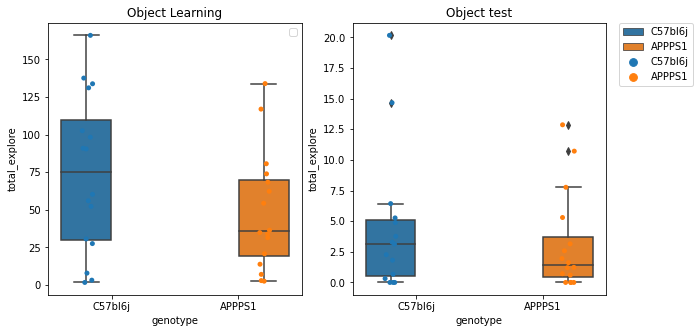

In [25]:
import seaborn as sns

fig,ax = plt.subplots(1,2,figsize=(10,5))
ax = ax.ravel()
plt.subplots_adjust(wspace=0.2)

idx = df_processed["condition"] == "test"
sns.boxplot(x='genotype',y='total_explore',hue='genotype',data=df_processed[~idx],ax=ax[0])
sns.boxplot(x='genotype',y='total_explore',hue='genotype',data=df_processed[idx],ax=ax[1])
sns.stripplot(x='genotype',y='total_explore',hue='genotype',data=df_processed[~idx],ax=ax[0],dodge=True)
sns.stripplot(x='genotype',y='total_explore',hue='genotype',data=df_processed[idx],ax=ax[1],dodge=True)
ax[0].set_title('Object Learning')
ax[1].set_title('Object test')
ax[0].legend('')
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

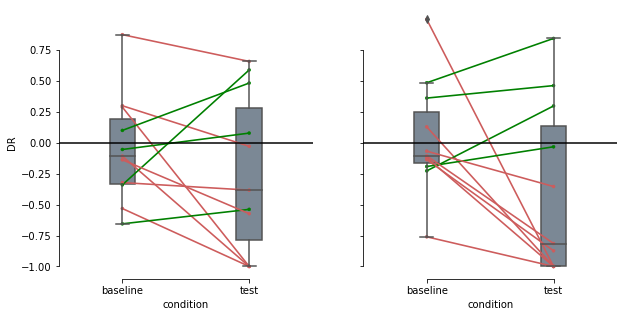

In [88]:
fig,ax = plt.subplots(1,2,figsize=(10,5),sharey=True)
ax = ax.ravel()
plt.subplots_adjust(wspace=0.2)
idx = (df_processed['genotype'] == 'APPPS1')
pg.plot_paired(data=df_processed[~idx], dv='DR', within='condition',
                    subject='subid_treatment_paradigm', dpi=150,ax=ax[0])
pg.plot_paired(data=df_processed[idx], dv='DR', within='condition',
                    subject='subid_treatment_paradigm', dpi=150,ax=ax[1])
ax[0].axhline(0,color='black')
ax[1].axhline(0,color='black')




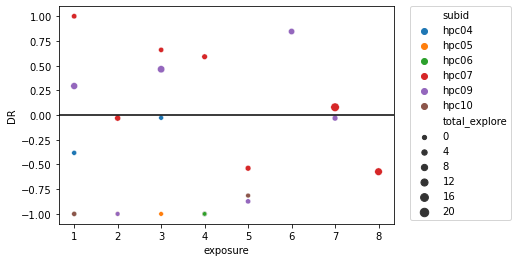

In [87]:
sns.scatterplot(x='exposure',y='DR',hue='subid',size='total_explore',data = df_processed[df_processed['condition'] == 'test'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(0,color='black')

In [72]:
df1.keys()

Index(['file', 'start', 'stop', 'object', 'subid', 'genotype', 'vidname',
       'basename', 'exposure', 'condition', 'treatment', 'objects', 'paradigm',
       'moved_object', 'trial_start_1', 'trial_stop_1', 'trial_start_2',
       'trial_stop_2', 'trial_start_3', 'trial_stop_3',
       'object_exploration_time', 'first_5min', 'first_3min',
       'all_baseline_5min_test', 'trial_n', 'all_baseline_3min_test'],
      dtype='object')